The Community Aerosol and Radiation Model for Atmospheres, [CARMA](https://github.com/ESCOMP/CARMA), can be configured and run through musica. This tutorial walks through creating a series of small CARMA model runs of increasing complexity.

First, we need to import our packages

In [1]:
import xarray as xr
import musica
import matplotlib.pyplot as plt
import numpy as np

Next we will define a few helper functions which will create a dataset for us.

In [2]:
def _extract_bin_data(data, key, nbin, nelem):
    # input data is time * bin * elem, each element contains data for each vertical level
    # so output should be time * bin * elem * z
    result = []
    for data_step in data:
        step_data = []
        for i in range(nbin):
            bin_data = []
            for j in range(nelem):
                bin_data.append(data_step[i][j][key])
            step_data.append(bin_data)
        result.append(step_data)
    # result is time * bin * elem * z
    # transpose to match expected output shape: time * z * bin * elem
    return np.transpose(result, (0, 3, 1, 2))

def _extract_scalar_bin_data(data, key, nbin, nelem):
    result = []
    for data_step in data:
        step_data = []
        for i in range(nbin):
            bin_data = []
            for j in range(nelem):
                bin_data.append(data_step[i][j][key])
            step_data.append(bin_data)
        result.append(step_data)
    return result

def extract_data(params, state, env, bin_data, time_array):
    nz = params.nz
    nbin = params.nbin
    nelem = len(params.elements)
    ngroup = len(params.groups)
    ngas = len(params.gases)
    nstep = params.nstep

    # Create coordinates
    coords = {}

    # Spatial coordinates
    vertical_center = state.vertical_center
    vertical_levels = state.vertical_levels

    coords['lat'] = ('y', [state.latitude])
    coords['lon'] = ('x', [state.longitude])
    coords['z'] = ('z', vertical_center, {
                   'units': 'm', 'long_name': 'Vertical center height'})
    coords['z_levels'] = ('z_levels', vertical_levels, {
                          'units': 'm', 'long_name': 'Vertical interface height'})
    coords['time'] = ('time', time_array, {'units': 's', 'long_name': 'Time'})

    # Bin coordinates (1-indexed like Fortran)
    coords['bin'] = ('bin', list(range(1, nbin + 1)))
    coords['group'] = ('group', list(range(1, ngroup + 1)))
    coords['elem'] = ('elem', list(range(1, nelem + 1)))
    coords['nwave'] = ('nwave', list(
        range(1, len(params.wavelength_bins) + 1)))

    data_vars = {}

    # Atmospheric state variables
    pressure = [env[i]['pressure'] for i in range(len(env))]
    temperature = [env[i]['temperature'] for i in range(len(env))]
    air_density = [env[i]['air_density'] for i in range(len(env))]

    data_vars['pressure'] = (
        ('time', 'z'), pressure, {'units': 'Pa', 'long_name': 'Pressure'})
    data_vars['temperature'] = (
        ('time', 'z'), temperature, {'units': 'K', 'long_name': 'Temperature'})
    data_vars['air_density'] = (
        ('time', 'z'), air_density, {'units': 'kg m-3', 'long_name': 'Air density'})

    # bin_data is time * bin * elem, each element contains data for each vertical level
    # so bin_data's shape is: time * bin * elem * z

    # Vector data (with z-dimension)
    data_vars['mass_mixing_ratio'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'mass_mixing_ratio', nbin, nelem), {
            'units': 'kg kg-1', 'long_name': 'Mass mixing ratio'})
    data_vars['number_mixing_ratio'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'number_mixing_ratio', nbin, nelem), {
            'units': '# kg-1', 'long_name': 'Number mixing ratio'})
    data_vars['number_density'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'number_density', nbin, nelem), {
            'units': '# cm-3', 'long_name': 'Number density'})
    data_vars['nucleation_rate'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'nucleation_rate', nbin, nelem), {
            'units': '# cm-3 s-1', 'long_name': 'Nucleation rate'})
    data_vars['wet_particle_radius'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'wet_particle_radius', nbin, nelem), {
            'units': 'cm', 'long_name': 'Wet particle radius'})
    data_vars['wet_particle_density'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'wet_particle_density', nbin, nelem), {
            'units': 'g cm-3', 'long_name': 'Wet particle density'})
    data_vars['dry_particle_density'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'dry_particle_density', nbin, nelem), {
            'units': 'g cm-3', 'long_name': 'Dry particle density'})
    data_vars['fall_velocity'] = (
        ('time', 'z_levels', 'bin', 'elem'), _extract_bin_data(bin_data, 'fall_velocity', nbin, nelem), {
            'units': 'cm s-1', 'long_name': 'Fall velocity'})
    data_vars['delta_particle_temperature'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'delta_particle_temperature', nbin, nelem), {
            'units': 'K', 'long_name': 'Delta particle temperature'})
    data_vars['kappa'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'kappa', nbin, nelem), {
            'units': '', 'long_name': 'Hygroscopicity parameter'})
    data_vars['total_mass_mixing_ratio'] = (
        ('time', 'z', 'bin', 'elem'), _extract_bin_data(bin_data, 'total_mass_mixing_ratio', nbin, nelem), {
            'units': 'kg m-3', 'long_name': 'Total mass mixing ratio'})

    # Scalar data (no z-dimension)
    data_vars['particle_mass_on_surface'] = (
        ('time', 'bin', 'elem'), _extract_scalar_bin_data(bin_data, 'particle_mass_on_surface', nbin, nelem), {
            'units': 'kg m-2', 'long_name': 'Mass of particle on surface'})
    data_vars['sedimentation_flux'] = (
        ('time', 'bin', 'elem'), _extract_scalar_bin_data(bin_data, 'sedimentation_flux', nbin, nelem), {
            'units': 'kg m-2 s-1', 'long_name': 'Sedimentation flux'})
    data_vars['deposition_velocity'] = (
        ('time', 'bin', 'elem'), _extract_scalar_bin_data(bin_data, 'deposition_velocity', nbin, nelem), {
            'units': 'cm s-1', 'long_name': 'Deposition velocity'})

    # Create the dataset
    return xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs={
            'title': 'CARMA aerosol model output',
            'description': 'Output from CARMA aerosol simulation',
            'nz': nz,
            'nbin': nbin,
            'nelem': nelem,
            'ngroup': ngroup,
            'ngas': ngas,
            'nstep': nstep
        }
    )


def extract_bin_data_for_timestep(params, state):
    nbin = params.nbin
    nelem = len(params.elements)
    bin_data = [[] for _ in range(nbin)]

    for i in range(nbin):
        for j in range(nelem):
            bin_data[i].append(state.get_bin(i + 1, j + 1))

    return bin_data


Finally, we can run a simple aluminum configuration. For now, we will use the pre-made configuraiton which hides the details of creating groups, elements, coagulation schemes so that we can get to running a simple box model quickly.

In [3]:
params = musica.CARMAParameters.create_aluminum_test_config()

carma = musica.CARMA(params)

state = carma.create_state(
    longitude=0.0,
    latitude=-105.0,
    coordinates=musica.carma.CarmaCoordinates.CARTESIAN,
)

mmr_initial = 5e9 / (params.deltaz * 2.57474699e14) / state.get_environmental_values()["air_density"][0]

for i in range(params.nbin):
    for j in range(len(params.elements)):
        state.set_bin(i + 1, j + 1, mmr_initial)

bin_data = [extract_bin_data_for_timestep(params, state)]
env = [state.get_environmental_values()]
time_array = [0.0]  # Start with time 0

# Run the simulation for the specified number of steps
for step in range(1, int(params.nstep)):
    state.step()
    bin_data.append(extract_bin_data_for_timestep(params, state))
    env.append(state.get_environmental_values())
    time_array.append(step * params.dtime)

ds = extract_data(params, state, env, bin_data, time_array)

In [4]:
ds

<xarray.Dataset> Size: 152kB
Dimensions:                     (time: 240, z: 1, bin: 5, elem: 1, z_levels: 2,
                                 y: 1, x: 1, group: 1, nwave: 0)
Coordinates:
    lat                         (y) float64 8B -105.0
    lon                         (x) float64 8B 0.0
  * z                           (z) float64 8B 1.7e+04
  * z_levels                    (z_levels) float64 16B 1.65e+04 1.75e+04
  * time                        (time) float64 2kB 0.0 1.8e+03 ... 4.302e+05
  * bin                         (bin) int64 40B 1 2 3 4 5
  * group                       (group) int64 8B 1
  * elem                        (elem) int64 8B 1
  * nwave                       (nwave) float64 0B 
Dimensions without coordinates: y, x
Data variables: (12/17)
    pressure                    (time, z) float64 2kB 8.85e+03 ... 8.85e+03
    temperature                 (time, z) float64 2kB 216.6 216.6 ... 216.6
    air_density                 (time, z) float64 2kB 0.1417 0.1417 ... 0.1417
    mass_mixing_ratio           (time, z, bin, elem) float64 10kB 1.37e-07 .....
    number_mixing_ratio         (time, z, bin, elem) float64 10kB 8.334e+08 ....
    number_density              (time, z, bin, elem) float64 10kB 118.1 ... 7.86
    ...                          ...
    delta_particle_temperature  (time, z, bin, elem) float64 10kB -999.0 ... ...
    kappa                       (time, z, bin, elem) float64 10kB 0.0 ... -1....
    total_mass_mixing_ratio     (time, z, bin, elem) float64 10kB 1.37e-07 .....
    particle_mass_on_surface    (time, bin, elem) float64 10kB 0.0 0.0 ... 0.0
    sedimentation_flux          (time, bin, elem) float64 10kB 0.0 0.0 ... 0.0
    deposition_velocity         (time, bin, elem) float64 10kB -999.0 ... -999.0
Attributes:
    title:        CARMA aerosol model output
    description:  Output from CARMA aerosol simulation
    nz:           1
    nbin:         5
    nelem:        1
    ngroup:       1
    ngas:         0
    nstep:        240.0

In [5]:
# convert from seconds to days
ds = ds.assign_coords(time=ds.time / 86400)

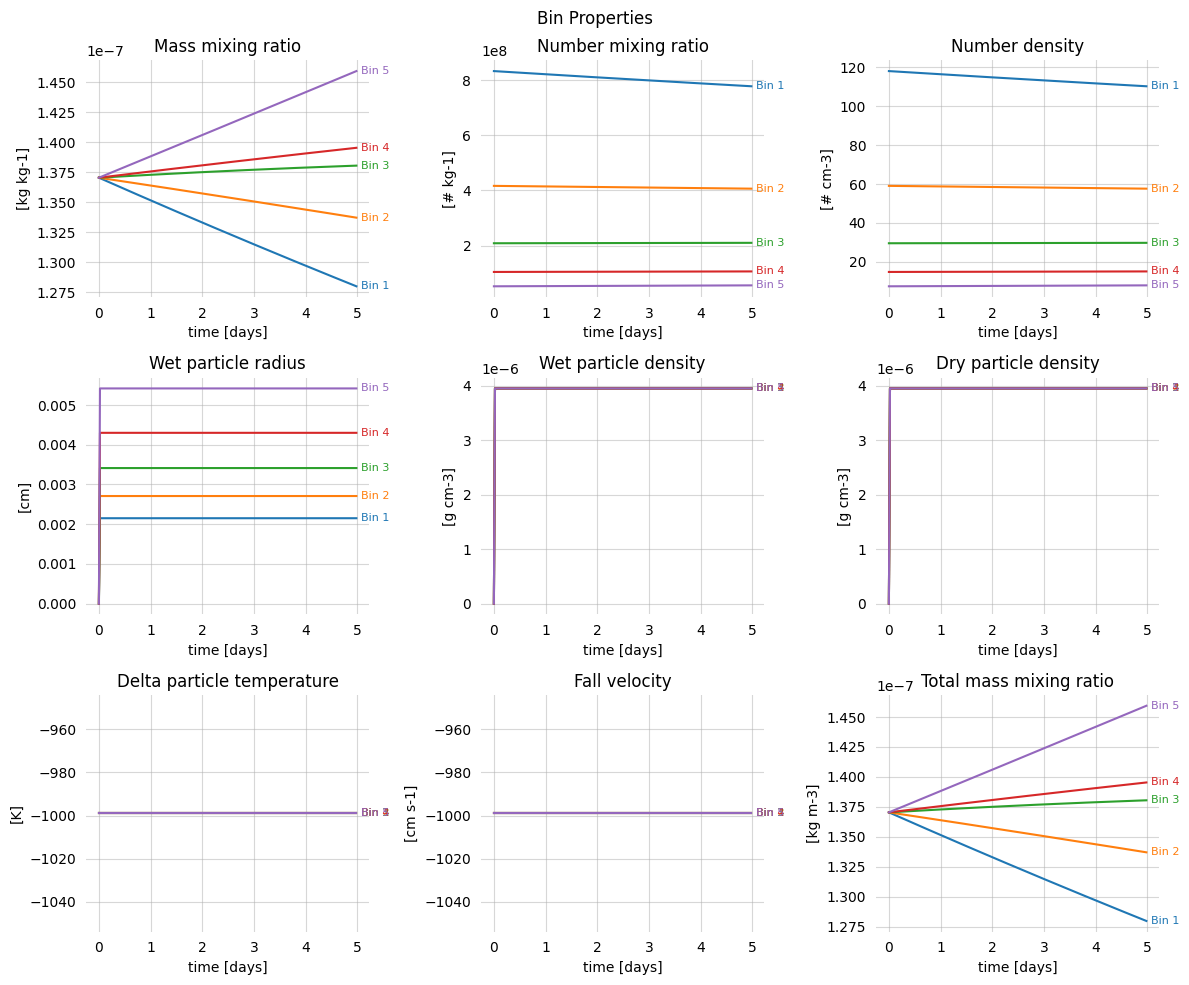

In [6]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'mass_mixing_ratio', 'number_mixing_ratio', 'number_density', 
    'wet_particle_radius', 'wet_particle_density', 'dry_particle_density',
    'delta_particle_temperature', 'fall_velocity', 'total_mass_mixing_ratio'
]

for var, ax in zip(vars, axs.ravel()):
    for i in range(5):  # 5 bins
        y = ds[var][:, 0, i, 0]
        line, = ax.plot(ds.time, ds[var][:, 0, i, 0], label=f'Bin {i+1}')
        buffer = (ds.time.values[-1] - ds.time.values[-2]) * 4.50
        ax.text(ds.time.values[-1] + buffer, y.values[-1], f'Bin {i+1}',
                va='center', ha='left', fontsize=8, color=line.get_color())
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('time [days]')
    ax.set_ylabel(f'[{ds[var].units}]')
    ax.set_title(f'{ds[var].long_name}')
    
fig.suptitle("Bin Properties")
fig.tight_layout()

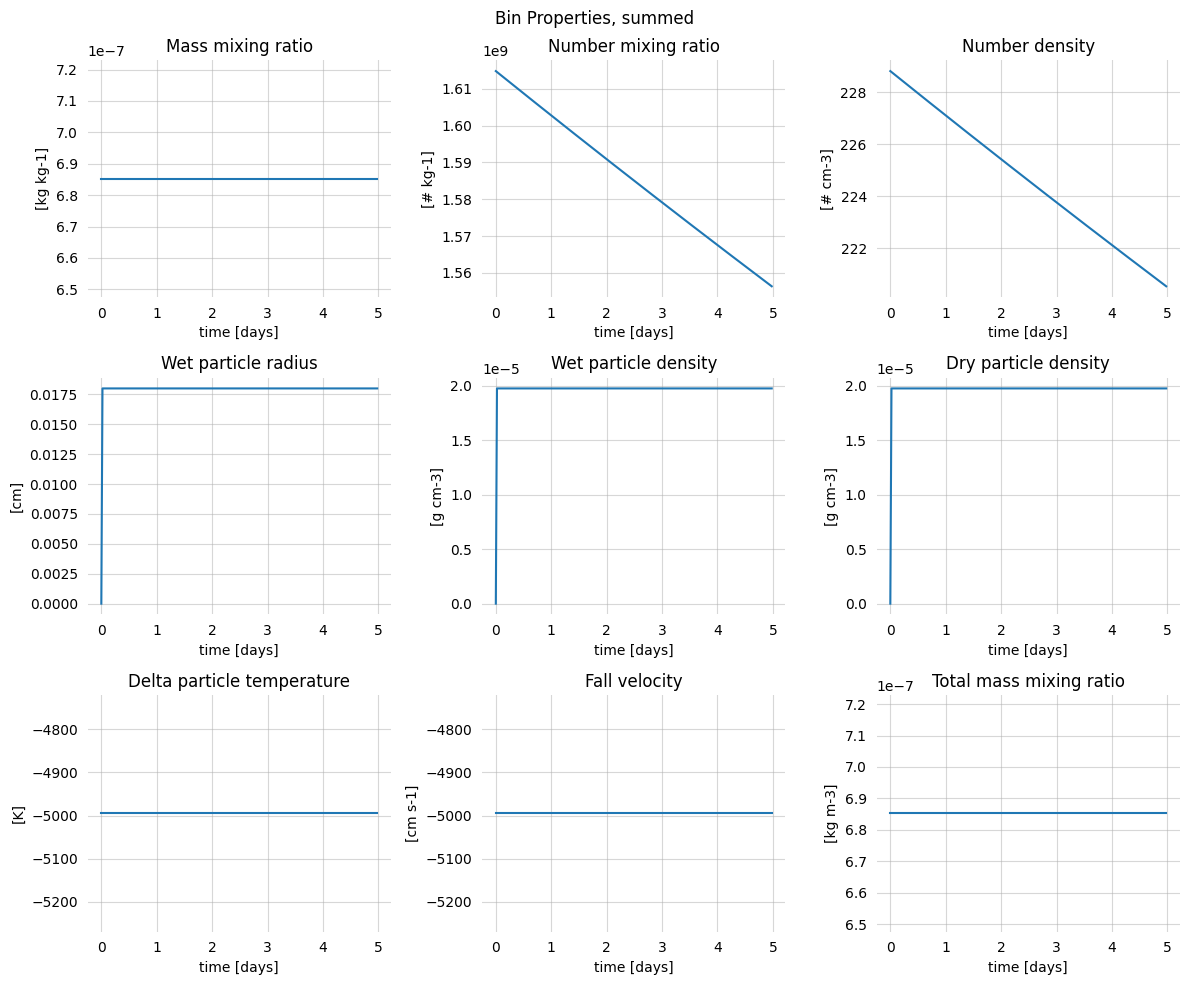

In [7]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'mass_mixing_ratio', 'number_mixing_ratio', 'number_density', 
    'wet_particle_radius', 'wet_particle_density', 'dry_particle_density',
    'delta_particle_temperature', 'fall_velocity', 'total_mass_mixing_ratio'
]

for var, ax in zip(vars, axs.ravel()):
    ax.plot(ds.time, ds[var].sum(dim='bin')[:, 0, 0])
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('time [days]')
    ax.set_ylabel(f'[{ds[var].units}]')
    ax.set_title(f'{ds[var].long_name}')
    
fig.suptitle("Bin Properties, summed")
fig.tight_layout()

In [8]:
group_config, group_props = carma.get_group_properties(1)

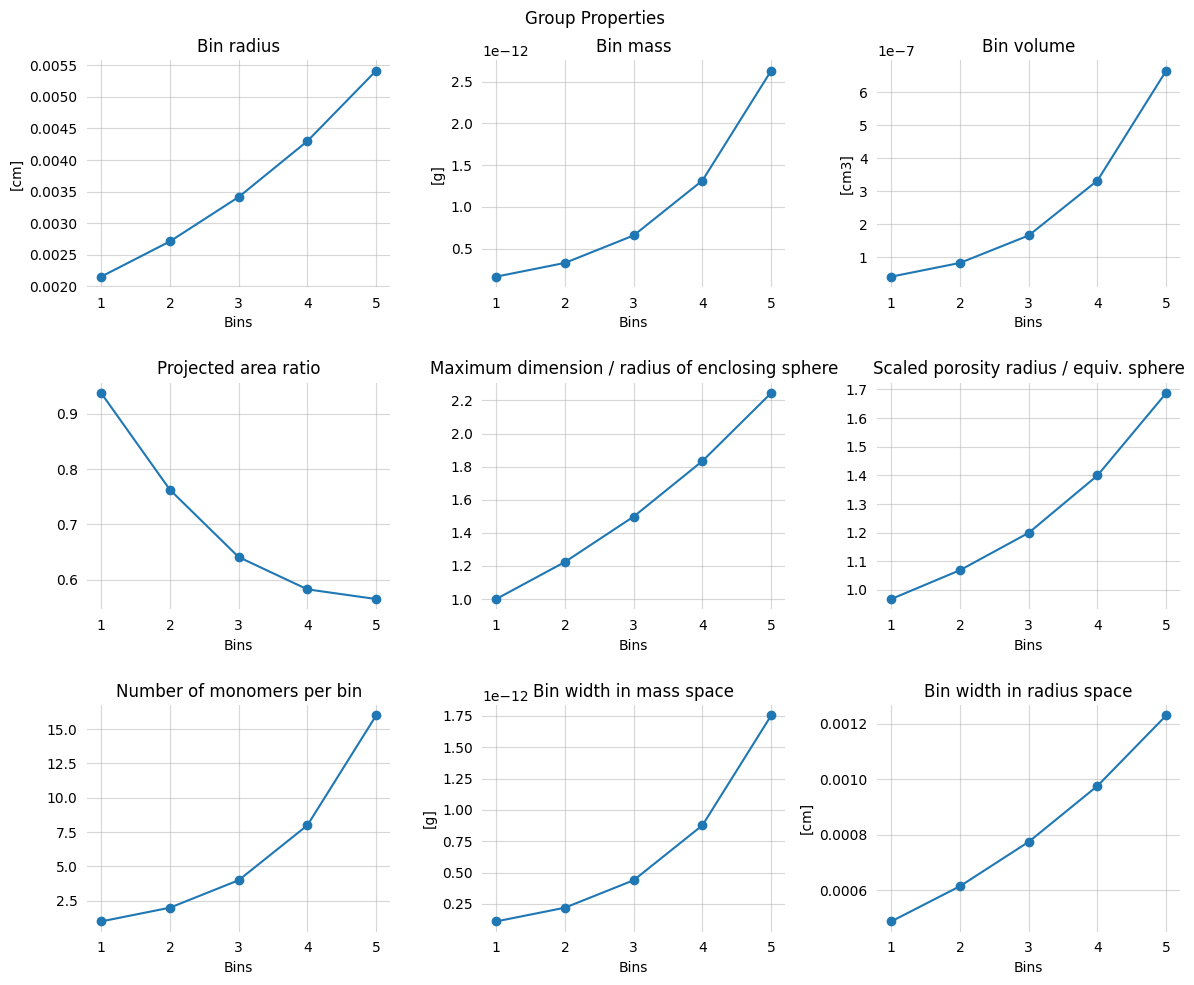

In [9]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3, ncols=3)

vars = [
    'bin_radius', 'bin_mass', 'bin_volume', 
    'projected_area_ratio', 'radius_ratio', 'porosity_ratio',
    'number_of_monomers_per_bin', 'bin_width_mass', 'bin_width'
]

name_to_label = {
    "bin_radius": "Bin radius",
    "bin_radius_lower_bound": "Lower bound of bin radius",
    "bin_radius_upper_bound": "Upper bound of bin radius",
    "bin_width": "Bin width in radius space",
    "bin_mass": "Bin mass",
    "bin_width_mass": "Bin width in mass space",
    "bin_volume": "Bin volume",
    "projected_area_ratio": "Projected area ratio",
    "radius_ratio": "Maximum dimension / radius of enclosing sphere",
    "porosity_ratio": "Scaled porosity radius / equiv. sphere",
    "extinction_coefficient": "Extinction coefficient",
    "single_scattering_albedo": "Single scattering albedo",
    "asymmetry_factor": "Asymmetry factor",
    "particle_number_element_for_group": "Index of element for particle number",
    "number_of_core_mass_elements_for_group": "Number of core mass elements",
    "element_index_of_core_mass_elements": "Indices of core mass elements",
    "last_prognostic_bin": "Last prognostic bin",
    "number_of_monomers_per_bin": "Number of monomers per bin"
}
name_to_units = {
    "bin_radius": "cm",
    "bin_radius_lower_bound": "cm",
    "bin_radius_upper_bound": "cm",
    "bin_width": "cm",
    "bin_mass": "g",
    "bin_width_mass": "g",
    "bin_volume": "cm3",
    "projected_area_ratio": "",
    "radius_ratio": "",
    "porosity_ratio": "",
    "extinction_coefficient": "m-1",
    "single_scattering_albedo": "",
    "asymmetry_factor": "",
    "particle_number_element_for_group": "",
    "number_of_core_mass_elements_for_group": "",
    "element_index_of_core_mass_elements": "",
    "last_prognostic_bin": "",
    "number_of_monomers_per_bin": ""
}

for var, ax in zip(vars, axs.ravel()):
    line, = ax.plot(group_props[var], marker='o')
    
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('Bins')
    ax.set_xticks(range(5))
    ax.set_xticklabels([1, 2, 3, 4, 5])
    if name_to_units[var]:
        ax.set_ylabel(f'[{name_to_units[var]}]')
    ax.set_title(f'{name_to_label[var]}')

fig.suptitle("Group Properties")
    
fig.tight_layout()

In [10]:
env_data = {
    key: np.array([d[key][0] if d[key] is not None else np.nan for d in env])
    for key in ['temperature', 'pressure', 'air_density']
}

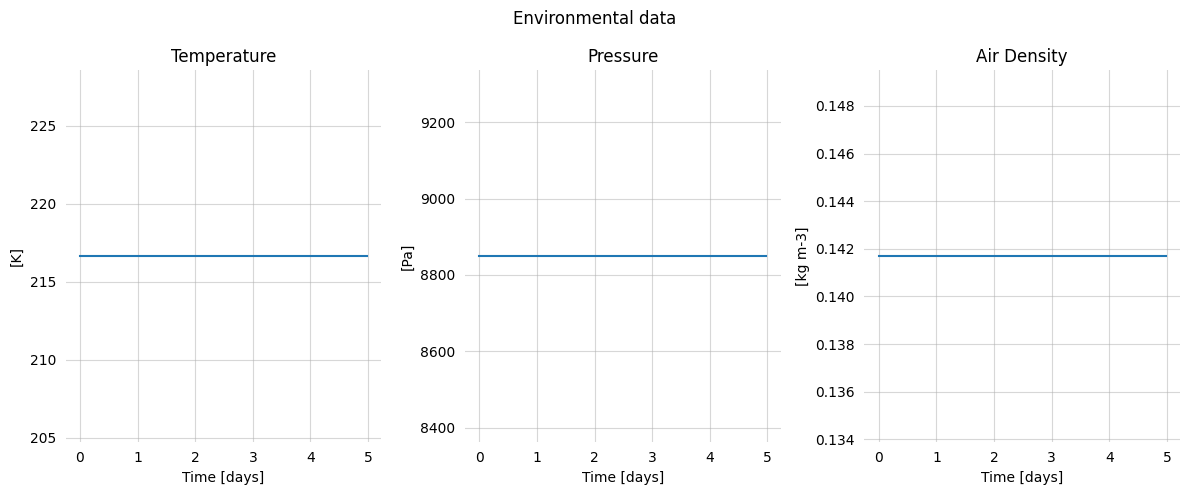

In [11]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=1, ncols=3)

vars = [
    'temperature', 'pressure', 'air_density'
]

name_to_label = {
    "temperature": "Temperature",
    "pressure": "Pressure",
    "air_density": "Air Density",
}
name_to_units = {
    "temperature": "K",
    "pressure": "Pa",
    "air_density": "kg m-3",
}

for var, ax in zip(vars, axs.ravel()):
    
    line, = ax.plot(ds.time, env_data[var])
    ax.spines[:].set_visible(False)
    ax.grid(alpha=0.5)
    ax.tick_params(width=0)
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(f'[{name_to_units[var]}]')
    ax.set_title(f'{name_to_label[var]}')

fig.suptitle("Environmental data")
    
fig.tight_layout()